### Covariance Matrix calculations and plots

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from helpers import plot_class
from helpers import helpfunction as helper

In [2]:
sideband = True

pot_dict = {}
master_query = "(slpdg==12)"
title_str = ''
pi0_scale_bool = True
dirt_bool = True
show_lee_bool = False
maximum_uni_per_type = 5000

if not sideband: # Full unblinded data.
    full_sample = True
    print('Unblinded sample')
    beam_on = "on"
    master_query += ("& optical_filter")
    
else:
    full_sample = False
    title_str = r"Reconstructed $\nu_e$ Energy > 0.9 GeV"
    beam_on = 'sideband'
    master_query += ("& optical_filter & (reco_e>0.9)")
    
print(beam_on,pot_dict, master_query)
input_file = "./input/July2020/lite/after_training.pckl"
output_dir = "./output/nue/datamc/{}/".format(beam_on)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

sideband {} (slpdg==12)& optical_filter & (reco_e>0.9)


In [3]:
plotter = plot_class.Plotter(
    input_file,
    signal="nue",
    genie_version="mcc9.1",
    beam_on=beam_on,
    dirt = dirt_bool,
    pot_dict=pot_dict,
    master_query=master_query,
    load_syst= helper.syst_weights,
    show_lee = show_lee_bool,
    pi0_scaling= pi0_scale_bool,
    n_uni_max=maximum_uni_per_type,
    write_slimmed_output = False
)

Applying the master query on the systematic universes
weightsFlux
weightsGenie
weightsReint
Using the spline weights as in MCC9.1 Genie V3 tune 1
Empirical scaling of 1-0.4*E applied on events with neutral pions.
data[beam_on]["pot"] {(9, 0): 6.849e+20}
data[beam_on]["triggers"] {(9, 0): 160471177.0}
data[beam_off]["triggers"] {(2, 1): 65353724.0, (2, 0): 151574089.0, (2, 3): 205406582.0}
All plots are scaled to 6.85e+20 POT, Beam_on data corresponds to 6.85e+20 POT
Loaded all daughter dataframes.
Started loading systematic weights.

Loaded all universes for weightsFlux.
Loaded all universes for weightsGenie.
Loaded all universes for weightsReint.
Initialisation completed!


In [25]:
# Get Covariance matrix
field = "shr_energy_y_v/1000"
label = "Electron shower energy [GeV]"
N_bins=12
x_min=0.1
x_max=2.5
query="(select & e_candidate)"

temp_view = plotter.mc_daughters.query(query)
cv_data = temp_view.eval(field)
cv_weights = temp_view["plot_weight"]
cv_bins, bin_edges = np.histogram(cv_data, weights=cv_weights, range=(x_min,x_max),bins=N_bins)
cov = plotter.get_cov(bin_edges, query, cv_data, cv_weights)

In [17]:
fr_cov = cov / np.outer(cv_bins,cv_bins)

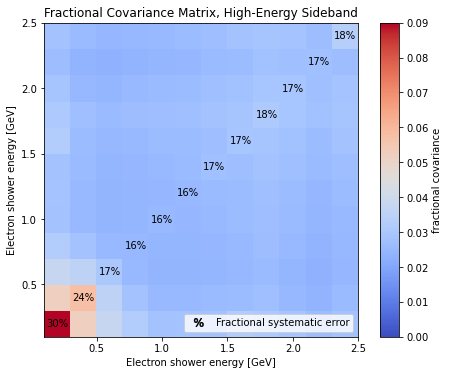

In [58]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6.2,5.1))

im = ax.pcolormesh(bin_edges, bin_edges, fr_cov, cmap='coolwarm',vmin=0, vmax=0.09)
fig.colorbar(im, ax=ax, label = 'fractional covariance')
ax.set_title('Fractional Covariance Matrix, High-Energy Sideband')
ax.set_xlabel(label)
ax.set_ylabel(label)
ax.set_aspect('equal')
fig.savefig(output_dir+'fractional_cov.pdf')

bin_mids = (bin_edges[1:] + bin_edges[:-1])/2
for i in range(len(cov)):
        text = ax.text(bin_mids[i], bin_mids[i], '{:0.0%}'.format(np.sqrt(fr_cov[i][i])),
                       ha="center", va="center", color="k")
ax.plot([], [], label="Fractional systematic error", alpha=1, marker='$\%$',color='k', lw=0, mew=0.6, ms=10)                  
ax.legend(loc='lower right')
fig.savefig(output_dir+'fractional_cov.pdf')